<a href="https://colab.research.google.com/github/lovelesh-singla/Coursera_Capstone/blob/master/ExploringTorontoNeighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Exploring Toronto Neighborhoods to open an Indian Restaurant.</h1></center>

As a part of the final IBM Capstone Project, we work on the real dataset to get an exprencies of what a data scientists go through in real life. Objectives of the final assignments were to define a business problem, look for data in the web and, use Foursquare location data to compare different neighborhoods of Toronto to figure out which neighborhood is suitable for starting a new restaurant business. In this project, I go through all the process in a step by step manner from problem designing, data preparation to final analysis and finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.







<h2>1. Description of the Problem and Discussion of the Background (Introduction Section)</h2>


<h3>Prospects of a opening an Indian Restaurant in Toronto, Canada.</h3>


Toronto, the capital of the province of Ontario, is the most populous Canadian city. Its diversity is reflected in Toronto’s ethnic neighborhoods such as Chinatown, Corso Italia, Greektown, Kensington Market, Koreatown, Little India, Little Italy, Little Jamaica, Little Portugal & Roncesvalles. One of the most immigrant-friendly cities in North America with more than half of the entire Indian Canadian population residing in Toronto it is one of the best places to start an Indian restaurant.

In this project we will go through step by step process to make a decision whether it is a good idea to open an Indian restaurant. We analyze the neighborhoods in Toronto to identify the most profitable area since the success of the restaurant depends on the people and ambience. Since we already know that Toronto shelter a greater number of Indians than any other city in Canada, it is a good idea to start the restaurant here, but we just need to make sure whether it is a profitable idea or not. If so, where we can place it, so it yields more profit to the owner.


![Toronto.jpg](attachment:Toronto.jpg)

<h3>Target Audience</h3>

Who will be more interested in this project? What type of clients or a group of people would be benefitted?
1.	Business personnel who wants to invest or open an Indian restaurant in Toronto. This analysis will be a comprehensive guide to start or expand restaurants targeting the Indian crowd.
2.	Freelancer who loves to have their own restaurant as a side business. This analysis will give an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.
3.	Indian crowd who wants to find neighborhoods with lots of option for Indian restaurants. 
4.	Business Analyst or Data Scientists, who wish to analyze the neighborhoods of Toronto using Exploratory Data Analysis and other statistical & machine learning techniques to obtain all the necessary data, perform some operations on it and, finally be able to tell a story out of it.


<h2>2. Data acquisition and cleaning</h2>


<h3>2.1 Data Sources</h3>


a) I’m using “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) wiki page to get all the information about the neighborhoods present in Toronto. This page has the postal code, borough & the name of all the neighborhoods present in Toronto. 

b) Then I’m using “https://cocl.us/Geospatial_data” csv file to get all the geographical coordinates of the neighborhoods. 

c) To get information about the distribution of population by their ethnicity I’m using “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) wiki page. Using this page I’m going to identify the neighborhoods which are densely populated with Indians as it might be helpful in identifying the suitable neighborhood to open a new Indian restaurant. 

d) To get location and other information about various venues in Toronto I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in Toronto and collected their names, categories and locations (latitude and longitude). 
From Foursquare API (https://developer.foursquare.com/docs), I retrieved the following for each venue:
<li>Name: The name of the venue. </li>
<li>Category: The category type as defined by the API.</li>
<li>Latitude: The latitude value of the venue.</li>
<li>Longitude: The longitude value of the venue.</li>


<h3>2.2 Data Cleaning</h3>

<h4>a) Scraping Toronto Neighborhoods Table from Wikipedia</h4>

#### Scraped the following Wikipedia page, “List of Postal code of Canada: M” in order to obtain the data about the Toronto & the Neighborhoods in it.

<u> Assumptions made to attain the below DataFrame:</u>
<li>Dataframe will consist of three columns: PostalCode, Borough, and Neighborhood</li>
<li>Only the cells that have an assigned borough will be processed. Borough that is not assigned are ignored.</li>
<li>More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.</li>
<li>If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.</li>

wikipedia - package is used to scrape the data from wiki.

In [2]:
import pandas as pd
import numpy as np

In [3]:
html = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df = pd.read_html(html, header = 0)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df = df[df.Borough != 'Not assigned']
df = df.rename(columns={'Postal Code': 'Postalcode'})

#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. 
#So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']


df.head()

,Postalcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df = df.groupby(['Borough', 'Postalcode'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()
df.head()

,Borough,Postalcode,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


<h4>b) Adding geographical coordinates to the neighborhoods</h4>

Next important step is adding the geographical coordinates to these neighborhoods. To do so I'm extracting the data present in the Geospatial Data csv file and I'm combining it with the existing neighborhood dataframe by merging them both based on the postal code.  

In [7]:
#Reading the latitude & longitude data from CSV file

import io
import requests

url = "https://cocl.us/Geospatial_data"
lat_long = requests.get(url).text
lat_long_df=pd.read_csv(io.StringIO(lat_long))
lat_long_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


I'm renaming the columns to match the existing dataframe  

In [8]:
lat_long_df = lat_long_df.rename(columns={'Postal Code': 'Postalcode'})
lat_long_df.head()

,Postalcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


After that I'm merging both the dataframe into one by matching on the postal code. 

In [9]:
toronto_DF = pd.merge(df,lat_long_df, on='Postalcode')
toronto_DF = toronto_DF.rename(columns={'Neighbourhood':'Neighborhood'})
toronto_DF.head()

,Borough,Postalcode,Neighborhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_DF['Borough'].unique()),
        toronto_DF.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


<h4>c) Scrap the distribution of population from Wikipedia</h4>

Another factor that can help us in deciding which neighborhood would be best option to open a restaurant is, the distribution of population based on the ethnic diversity for each neighborhood. As this helps us in identifying the neighborhoods which are densely populated with Indian crowd since that neighborhood would be an ideal place to open an Indian restaurant. 

Scraped the following Wikipedia page, “Demographics of Toronto” in order to obtain the data about the Toronto & the Neighborhoods in it. Compared to all the neighborhoods in Toronto below given neighborhoods only had considerable amount of Indian crowd. We are examing those neighborhood's population to identify the densely populated neighborhoods with Indian population.

In [11]:
#overall population distribution 
html = "https://en.wikipedia.org/wiki/Demographics_of_Toronto"


In [16]:
#TORONTO & EAST YORK population distribution by ethnicity 
TEY_population_df = pd.read_html(html, header = 0)[12]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[13]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [18]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[14]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[15]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df



,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h4>d) Get location data using Foursquare</h4>

Foursquare API is very usefule online application used my many developers & other application like Uber etc. In this project I have used it to retrieve informtion about the places present in the neighborhoods of Toronto. The API returns a JSON file and we need to turn that into a data-frame. Here I’ve chosen 100 popular spots for each neighborhood within a radius of 1km. 



In [20]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

In [21]:
#Use geopy library to get the latitude and longitude values of New York City.

address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Defining Foursquare credentials

In [23]:
CLIENT_ID = '1CETT04VB4CLSAGO1IXLCHKKZHVZRSETNG0TXNWYPDA4SEY0' # your Foursquare ID
CLIENT_SECRET = 'Y2GSJIWDGC45VYYYGMV0ASLAC5FI21JECGRODK5GIRC31C0K' # your Foursquare Secret
ACCESS_TOKEN = 'RR1BSSE2OGRMAEYF3YDUYQ0AIDNGDXNM10VZ04ZZZ3DGLQYZ' # your FourSquare Access Token
VERSION = '20200605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [24]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()


In [25]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Using the get_category_type function, we clean up the json and turn it into a pandas dataframe. Before we start that we need to import certain libraries.

In [26]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Indigo,Bookstore,43.653515,-79.380696
4,Chatime 日出茶太,Bubble Tea Shop,43.655542,-79.384684


Now we can explore the nearby venues!

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=toronto_DF['Neighborhood'],
                                   latitudes=toronto_DF['Latitude'],
                                   longitudes=toronto_DF['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [30]:
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,HYC Design Inc.,43.726793,-79.391681,Business Service
2,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
3,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
4,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
5,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park
6,Davisville North,43.712751,-79.390197,Summerhill Market North,43.715499,-79.392881,Food & Drink Shop
7,Davisville North,43.712751,-79.390197,Winners,43.713236,-79.393873,Department Store
8,Davisville North,43.712751,-79.390197,Best Western Roehampton Hotel & Suites,43.708878,-79.390880,Hotel
9,Davisville North,43.712751,-79.390197,Subway,43.708474,-79.390674,Sandwich Place


In [31]:
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,4,4,4,4,4,4


In [32]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))


There are 268 uniques categories.


There are 274 unique categories in which Indian Restaurant is one of them. We will do one hot encoding for getting dummies of venue category. So that we will calculate mean of all venue groupby there neighborhoods.


In [33]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped



,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,...,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.052632,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.04,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.029412,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029412,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.00
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

In [34]:
print (toronto_venues['Venue Category'].value_counts())


Coffee Shop         183
Café                 93
Restaurant           63
Park                 55
Pizza Place          52
                   ... 
Auto Workshop         1
Airport Terminal      1
Hobby Shop            1
Climbing Gym          1
College Stadium       1
Name: Venue Category, Length: 268, dtype: int64


<h2>3. Exploratory Data Analysis</h2>


<h3>3.1 Folium Library and Leaflet Map</h3>

Folium is a python library, I'm using it to draw an interactive leaflet map using coordinate data. 


In [35]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_DF['Latitude'], toronto_DF['Longitude'], toronto_DF['Borough'], toronto_DF['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<h3>3.2 Relationship between neighborhood and Indian Restaurant </h3>

First we will extract the Neighborhood and Indian Restaurant column from the above toronto dataframe for further analysis:

In [36]:
toronto_part = toronto_grouped[['Neighborhood', 'Indian Restaurant']]
toronto_part

,Neighborhood,Indian Restaurant
0,Agincourt,0.00
1,"Alderwood, Long Branch",0.00
2,"Bathurst Manor, Wilson Heights, Downsview North",0.00
3,Bayview Village,0.00
4,"Bedford Park, Lawrence Manor East",0.04
...,...,...
91,"Willowdale, Willowdale East",0.00
92,"Willowdale, Willowdale West",0.00
93,Woburn,0.00
94,Woodbine Heights,0.00


In [37]:
toronto_merged = pd.merge(toronto_DF, toronto_part, on='Neighborhood')
toronto_merged

,Borough,Postalcode,Neighborhood,Latitude,Longitude,Indian Restaurant
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,0.000000
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,0.000000
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,0.000000
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,0.027027
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,0.000000
...,...,...,...,...,...,...
95,York,M6C,Humewood-Cedarvale,43.693781,-79.428191,0.000000
96,York,M6E,Caledonia-Fairbanks,43.689026,-79.453512,0.000000
97,York,M6M,"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43.691116,-79.476013,0.000000
98,York,M6N,"Runnymede, The Junction North",43.673185,-79.487262,0.000000


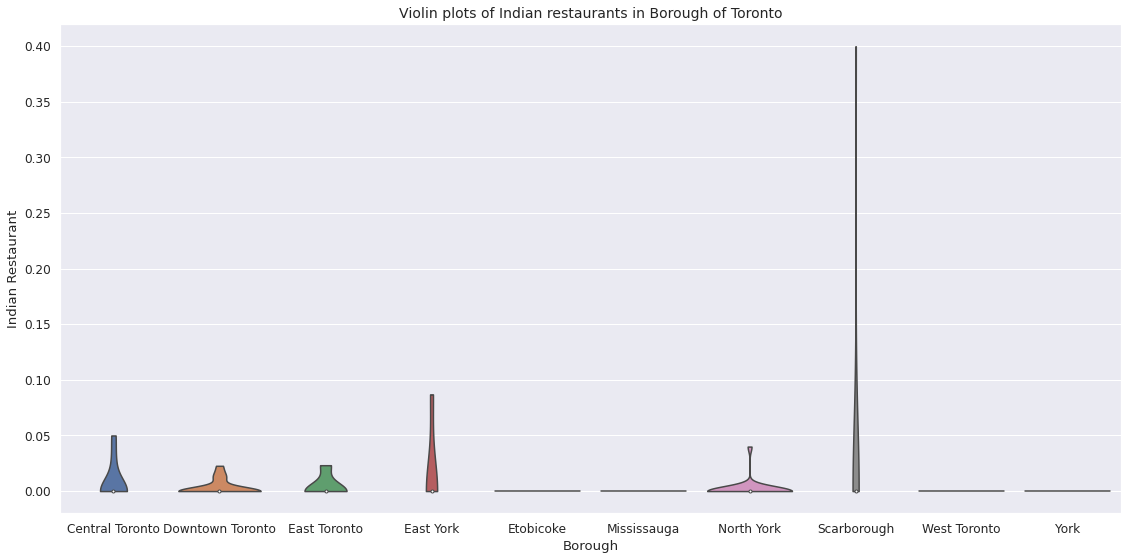

In [38]:
# Let's try Categorical plot 

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Indian Restaurant", x="Borough", data=toronto_merged, cut=0);

plt.title('Violin plots of Indian restaurants in Borough of Toronto', fontsize=14)
plt.show()

This plot helps in identifying the boroughs with densely populated Indian restaurants.  

Lets visualize the neighborhood with Indian Restaurants

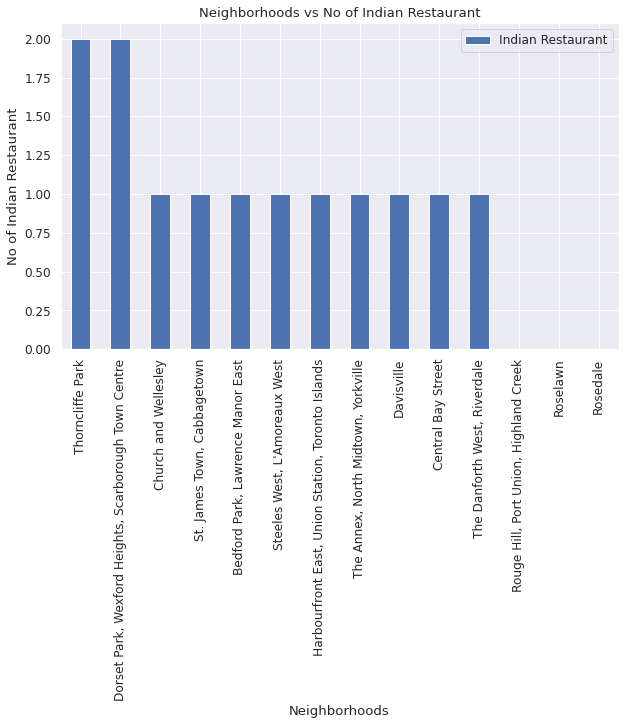

In [39]:
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Indian Restaurant'].sum())
graph = graph.sort_values(by ='Indian Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No of Indian Restaurant")
plt.title("Neighborhoods vs No of Indian Restaurant")
plt.show()


<h3>3.3 Relationship between neighborhood and Indian popultion </h3>

In [40]:
#Merge all the population table with the ethnic percentage by neighborhood
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


From the above dataframe we can pickout the neighborhoods with highest Indian population percentage by using the below given method. 

In [41]:
#Filtering the riding with Indian ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'East Indian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'East Indian')]
pop_indian_df = pd.DataFrame(temp).reset_index()
pop_indian_df.drop('index',axis=1,inplace=True)

pop_indian_df


,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
3,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN,NaN,NaN
5,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0,NaN,NaN
7,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN,NaN,NaN
8,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#retaining only Indian ethnic percentage & the neighborhood name 
columns_list = pop_indian_df.columns.to_list()
pop_indian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_indian_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_indian_df.at[i, j] == 'East Indian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_indian_DF_with_percent = pop_indian_DF_with_percent.append({'Riding':pop_indian_df.at[i, 'Riding'], 'Population':pop_indian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_indian_df.at[i, j], 'Percentage': pop_indian_df.at[i, percent_col]},ignore_index=True)

pop_indian_DF_with_percent      

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,East Indian,7.3,109060.0,Don Valley North
1,East Indian,9.2,107725.0,Humber River-Black Creek
2,East Indian,10.6,93170.0,Don Valley East
3,East Indian,12.2,110450.0,Scarborough Centre
4,East Indian,8.2,108295.0,Scarborough Southwest
5,East Indian,7.4,104225.0,Scarborough-Agincourt
6,East Indian,16.7,101445.0,Scarborough-Rouge Park
7,East Indian,18.0,101115.0,Scarborough-Guildwood
8,East Indian,11.8,97610.0,Scarborough North
9,East Indian,22.2,116960.0,Etobicoke North


In [43]:
pop_indian_DF_with_percent['Indian Population'] = (pop_indian_DF_with_percent['Percentage'] * pop_indian_DF_with_percent['Population'])/100
pop_indian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_indian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_indian_DF_with_percent

,Riding,Indian Population
0,Don Valley North,7961.380
1,Humber River-Black Creek,9910.700
2,Don Valley East,9876.020
3,Scarborough Centre,13474.900
4,Scarborough Southwest,8880.190
5,Scarborough-Agincourt,7712.650
6,Scarborough-Rouge Park,16941.315
7,Scarborough-Guildwood,18200.700
8,Scarborough North,11517.980
9,Etobicoke North,25965.120


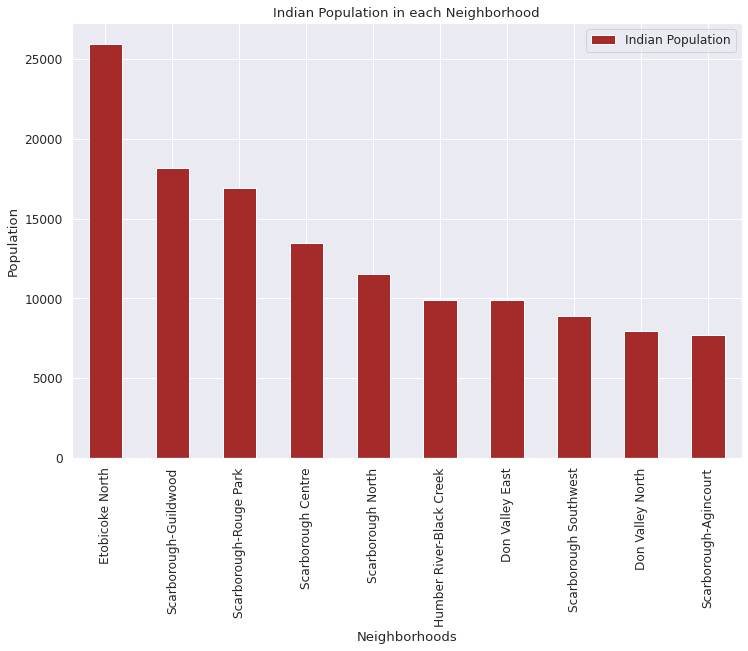

In [44]:
bar_graph = pop_indian_DF_with_percent.sort_values(by='Indian Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Indian Population',figsize=(12,8), color='brown')
plt.title("Indian Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

This analysis & visualization of the relationship between neighborhoods & indian population present in those neighborhoods helps us in identifying the highly populated indian neighborhoods. Once we identify those neighborhoods it helps us in deciding where to place the new Indian restaurant. Indian restaurant placed in an densely populated Indian neighborhood is more likely to get more Indian customers than a restaurant placed in a neighborhood with less or no Indian population. Thus this analysis helps in the determining the success of the new Indian restaurant. 

<h3>3.4 Relationship between Indian poplation and Indian restaurant </h3>

First get the list of neighborhoods present in the riding using the wikipedia geography section for each riding. Altering the riding names to match the wikipedia page so we can retrieve the neighborhoods present in those ridings

In [45]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_indian_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list

['Don Valley North',
 'Humber River-Black Creek',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Etobicoke North']

In [46]:
#Scraping wiki page to get the neighborhoods of ech Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wikipedia.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhoods':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhoods']]
Riding_neighborhood_df
    

ModuleNotFoundError: ignored

In [ ]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_indian_DF_with_percent, Riding_neighborhood_df, on='Riding')

Neigh_pop.drop(columns=['Riding'],inplace =True)
Neigh_pop



In [ ]:
Neigh_pop['split_neighborhoods'] = Neigh_pop['Neighborhoods'].str.split(',') 
Neigh_pop.drop(columns=['Neighborhoods'],inplace=True,axis=1)
Neigh_pop = Neigh_pop.split_neighborhoods.apply(pd.Series).merge(Neigh_pop, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Population'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

Neigh_pop.reset_index()
Neigh_pop

In [ ]:

toronto_part['split_neighborhoods'] = toronto_part['Neighborhood'].str.split(',') 
toronto_part.drop(columns=['Neighborhood'],inplace=True,axis=1)
toronto_part = toronto_part.split_neighborhoods.apply(pd.Series).merge(toronto_part, left_index = True, right_index = True).drop(["split_neighborhoods"], axis = 1)\
                    .melt(id_vars = ['Indian Restaurant'], value_name = "Neighborhood").drop("variable", axis = 1).dropna()

toronto_part.reset_index()
toronto_part

In [ ]:
pop_merged_restaurant_percent = pd.merge(Neigh_pop, toronto_part, on='Neighborhood')
pop_merged_restaurant_percent.head()



After performing the data cleaning & data analysis we can identify that their no big relationship established in terms of the Indian population & the popular Indian restaurants. 

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand. 

<h2>4. Predictive Modeling</h2>


<h3>4.1 Clustering Neighborhoods of Toronto:</h3>


First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset with Indian restaurant percentage (i.e. toronto_merged dataframe).

In [ ]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

In [ ]:
!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer


In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))

visualizer.fit(toronto_part_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

###### After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 6 is the best value.

<h4> Clustering the Toronto Neighborhood Using K-Means with K = 6 </h4>

In [ ]:
kclusters = 6

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

In [ ]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = toronto_DF
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

Let us see the clusters visually on the map with the help of Folium.

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

<h3>4.2 Examing the Clusters:</h3>


We have total of 6 clusters such as 0,1,2,3,4,5. Let us examine one after the other.



Cluster 0 contains all the neighborhoods which has least number of Indian restaurants. It is shown in red color in the map

In [ ]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

Cluster 1 contains the neighborhoods which is sparsely populated with Indian restaurants. It is shown in purple color in the map.

In [ ]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]


Cluster 2 has no rows meaning no data points or neighborhood was near to this centroid.

In [ ]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]


Cluster 3 contains all the neighborhoods which is medium populated with Indian restaurants. It is shown in blue color in the map.

In [ ]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]


Cluster 4 has no rows meaning no data points or neighborhood was near to this centroid. 

In [ ]:
#Cluster 4
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]


Cluster 5 contains all the neighborhoods which is densely populated with Indian restaurants. It is shown in Orange color in the map

In [ ]:
#Cluster 5
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5]


<h2>5. Results and Discussion:</h2>

<h3>5.1 Results</h3>


We have reached the end of the analysis, in the result section we can document all the findinds from above clustering & visualization of the datas. In this project, as the business problem started with identifying a good neighborhood to open a new Indian restaurant, we looked into all the neighborhoods in Toronto, analysed the Indian population in each neighborhood & spread of Indian restaurants in those neighborhoods to come to conclusion about which neighborhood would be a better spot for opening a new Indian restaurant. I have used data from web resources like Wikipedia, geospatial coordinates of Toronto neighborhoods, and Foursquare API, to set up a very realistic data-analysis scenario. We have found out that —


<li> In those 11 boroughs we identified that only Central Toronto, Downtown Tronto, East Toronto, East York, North York & Scarborough boroughs have high amount of Indian restaurants with the help of Violin plots between Number of Indian restaurants in Borough of Toronto. </li>



<li> In all the ridings, Scarborough-Guildwood, Scarborough-Rouge Park, Scarborough Centre, Scarborough North, Humber River-Black Creek, Don Valley East, Scarborough Southwest, Don Valley North & Scarborough-Agincourt are the densely populated with Indian crowd ridings. </li>

<li>With the help of clusters examing & violin plots looks like Downtown Toronto, Central Toronto, East York are already densely populated with Indian restaurants. So it is better idea to leave those boroughs out and consider only Scarborough, East Toronto & North York for the new restaurant's location.</li>

<li>After careful consideration it is a good idea to open a new Indian restaurant in Scarborough borough since it has high number of Indian population which gives a higher number of customers possibility and lower competition since very less Indian restaurants in the neighborhoods. </li>

<h3>5.2 Discussion</h3>

According to this analysis, Scarborough borough will provide least competition for the new upcoming Indian restaurant as there is very little Indian restaurants spread or no Indian restaurants in neighborhoods. Also looking at the population distribution looks like it is densely populated with Indian crowd which helps the new restaurant by providing hig customer visit possibilty. So, definitely this region could potentially be a perfect place for starting a quality Indian restaurants. Some of the drawbacks of this analysis are — the clustering is completely based only on data obtained from Foursquare API. Also the Indian population distribution in each neighborhood is also based on the 2016 census which is not up-to date. Thus population distribution would have definitely changed by 2019 given 3 years gap in the data. 
Since population distribution of Indian crowd in each neighborhood & number of Indian restaurants are the major feature in this analysis and it is not fully up-to date  data, this analysis is definitely not far from being conclusory & it has lot of areas where it can be imporved. However, it certainly provides us with some good insights, preliminary information on possibilites & a head start into this business problem by setting the step stones properly. Furthermore, this may also potentially vary depending on the type of clustering techniques that we use to examine the data.

<h2>6. Conclusion:</h2>

Finally to conclude this project, We have got a chance to on a business problem like how a real like data scientists would do. We have used many python libraries to fetch the data , to manipulate the contents & to analyze and visualize those datasets. We have made use of Foursquare API to explore the venues in enighborhoods of Toronto, then get good amount of data from Wikipedia which we scraped with help of Wikipedia python library and visualized using various plots present in seaborn & matplotlib. We also applied machine learning technique to to predict the output given the data and used Folium to visualize it on a map. Also, some of the drawbacks or areas of improvements shows us that this analysis can further be improved with help more data and different machine learning technique. Similarly we can use this project to analysis any scenario such opening a different cuisine or success of opening a new gym and etc. Hopefully, this project helps acts as initial guidance to take more complex real-life challenges using data-science.


In [ ]:
toronto_part.drop('Cluster Labels',axis=1, inplace=True)